In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import importlib
from sklearn.cluster import SpectralBiclustering
import drought_ibf_utility as ibf
importlib.reload(ibf)
plt.rcParams.update({'figure.max_open_warning': 0})

# Data Collection

Add text.

# Data Preprocessing

In [2]:
data = ibf.prepare_Uganda_data()

data.head()

year  District Season       EVI      NDVI  SPEI_12month  SPEI_3month  \
244  2001      ABIM  11_12 -0.087761 -0.109488      0.568272     1.014671   
245  2001      ABIM    6_7  0.176144  0.000840      1.202500     0.159914   
246  2001  ADJUMANI  11_12 -0.119269 -0.513605      0.096765    -0.190919   
247  2001  ADJUMANI    6_7 -1.100633 -0.769325     -0.991163     0.332131   
248  2001     AGAGO  11_12 -0.348043 -0.306330      0.032698     0.785683   

     SoilMoisture00_10cm  SoilMoisture100_200cm  SoilMoisture10_40cm  ...  \
244             0.493821               0.183495             0.532963  ...   
245             0.337568              -0.321696             0.178436  ...   
246            -0.035800              -0.161188            -0.029763  ...   
247             0.196787              -0.562899            -0.393729  ...   
248             0.384324               0.133650             0.363145  ...   

     SoilTemperature40_100cm  air_temperature  evapotranspiration  \
244                -0.517657        -0.304553            0.244027   
245                 0.071157         0.579569            1.411244   
246                -0.424694        -0.727866           -0.798907   
247                 0.325616         0.317138            0.817708   
248                -0.539449        -0.455596           -0.140299   

     precipitation_per_hour_v1  precipitation_per_hour_v2  rainfall  \
244                   0.929294                  -0.254581  0.823853   
245                   1.397528                   0.528161  0.546848   
246                  -1.046109                  -1.451136 -0.588187   
247                  -0.172741                  -0.394678  0.565755   
248                   0.084176                  -0.197233  0.337310   

     surface_temperature_daytime  surface_temperature_nighttime  wind_speed  \
244                    -0.334808                      -0.132387   -1.004612   
245                     0.105517                      -0.629675   -0.137186   
246                     0.817745                      -0.657459   -1.411771   
247                     1.034436                       0.602927   -0.037417   
248                    -0.057694                      -0.406609   -0.944500   

     drought_reported  
244             False  
245             False  
246             False  
247             False  
248             False  

[5 rows x 24 columns]

In [3]:
id_cols = ['year','District','Season']
label_name = 'drought_reported'
All_features = list(data.drop(labels=id_cols+[label_name],                                axis=1).columns)
selected_features = All_features

# Data Exploration

In [4]:
reduced_data = ibf.reduce_data(data,label_name)

## Correlations among the features

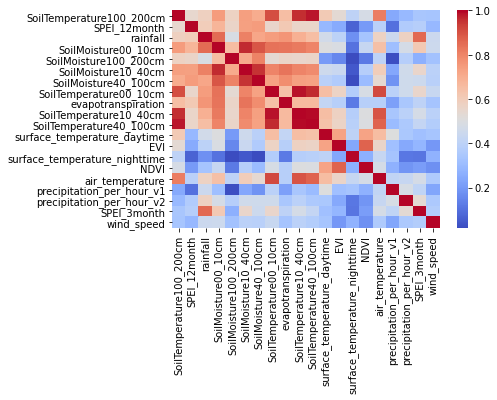

In [5]:
features = reduced_data[All_features].copy()
feature_corr = features.corr().abs()

bicluster_model = SpectralBiclustering(n_clusters=3, method='log',
                             random_state=0)
bicluster_model.fit(feature_corr)
feature_corr_sorted = feature_corr.values[np.argsort(bicluster_model.row_labels_),:]
feature_corr_sorted = feature_corr_sorted[:, np.argsort(bicluster_model.column_labels_)]
rows = feature_corr.columns[np.argsort(bicluster_model.row_labels_)]
cols = feature_corr.columns[np.argsort(bicluster_model.column_labels_)]
feature_corr_sorted = pd.DataFrame(feature_corr_sorted,index=rows,columns=cols)
sns.heatmap(feature_corr_sorted,cmap='coolwarm');

## Correlation with the target

In [6]:
median_vals = reduced_data[All_features+[label_name]].groupby(label_name).median().T.reset_index()
median_vals.rename(columns={True:'yes_drought', 
                            False:'no_drought', 
                            'Is_drought':'index',
                           'index':'feature'}, inplace= True)
median_vals['difference'] = (median_vals['yes_drought']-median_vals['no_drought']).abs()
median_vals.sort_values('difference',ascending=False,inplace=True)
median_vals.reset_index(inplace=True,drop=True)
median_vals.columns.name = None 
median_vals

feature  no_drought  yes_drought  difference
0             SoilMoisture00_10cm    0.284386    -0.513541    0.797927
1             SoilMoisture10_40cm    0.220404    -0.508178    0.728583
2       precipitation_per_hour_v2    0.076322    -0.632373    0.708695
3            SoilMoisture40_100cm    0.210898    -0.495211    0.706109
4                        rainfall    0.155648    -0.482576    0.638223
5              evapotranspiration    0.029240    -0.580077    0.609318
6        SoilTemperature100_200cm   -0.278042     0.288547    0.566590
7         SoilTemperature40_100cm   -0.220975     0.277648    0.498623
8          SoilTemperature10_40cm   -0.198435     0.286102    0.484537
9          SoilTemperature00_10cm   -0.132736     0.304152    0.436889
10                   SPEI_12month    0.140437    -0.268563    0.409000
11                    SPEI_3month    0.205554    -0.168369    0.373923
12                            EVI    0.219121    -0.138883    0.358004
13                     wind_speed   -0.023145     0.326113    0.349258
14      precipitation_per_hour_v1   -0.260609    -0.569718    0.309109
15                           NDVI    0.152977    -0.125642    0.278619
16    surface_temperature_daytime   -0.099576     0.146634    0.246209
17          SoilMoisture100_200cm    0.050536    -0.140272    0.190808
18                air_temperature   -0.117272     0.016762    0.134033
19  surface_temperature_nighttime    0.126235     0.256241    0.130006

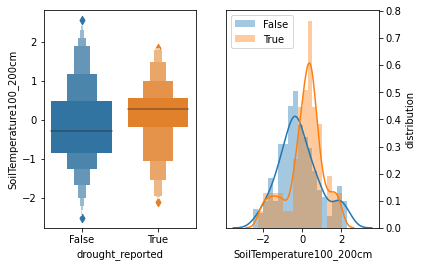

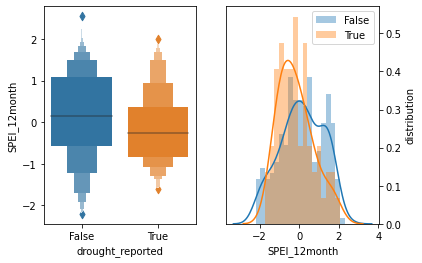

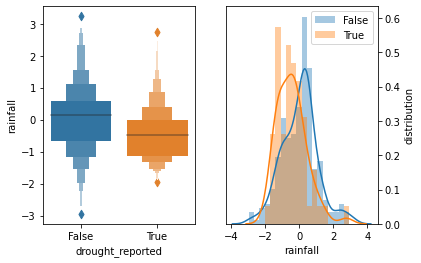

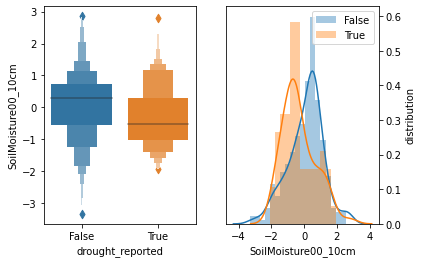

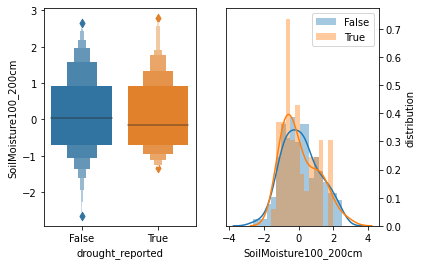

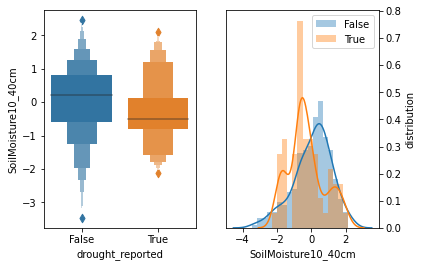

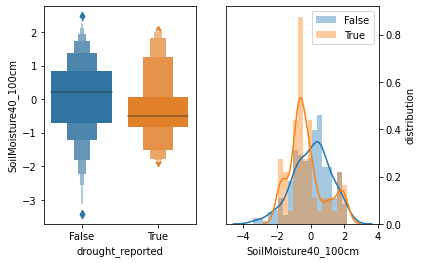

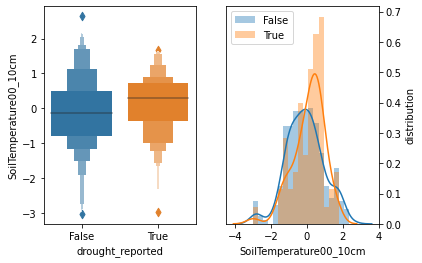

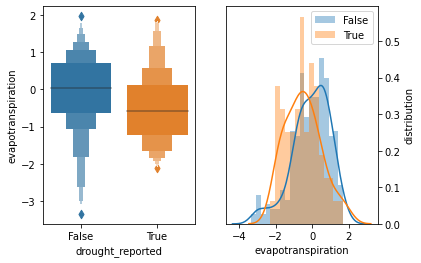

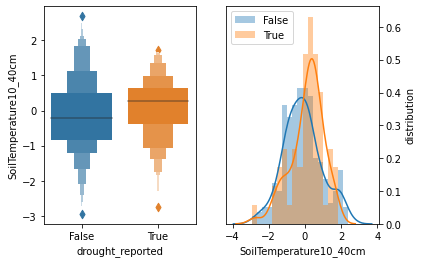

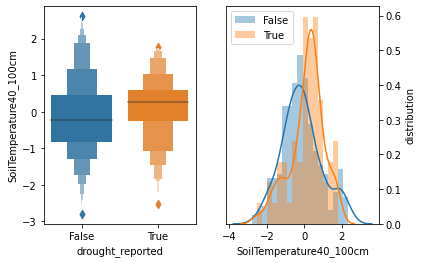

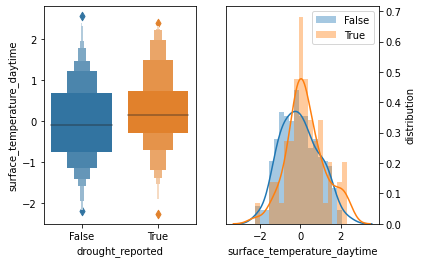

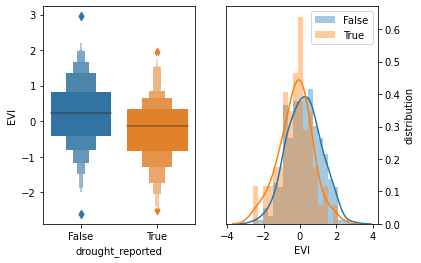

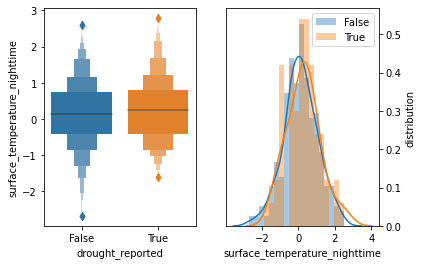

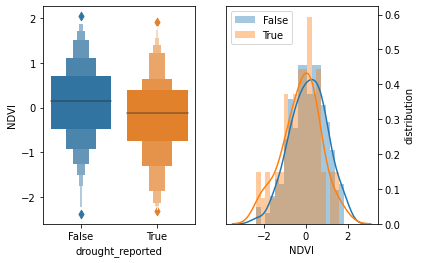

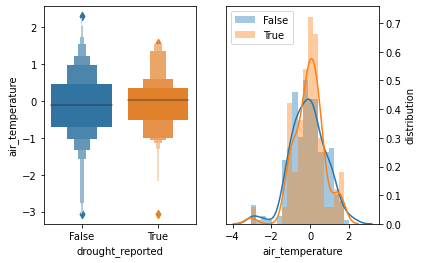

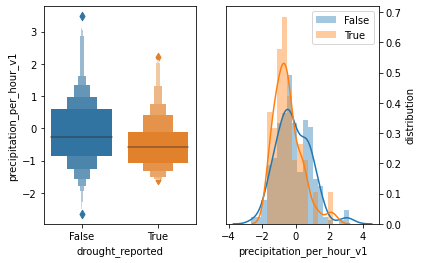

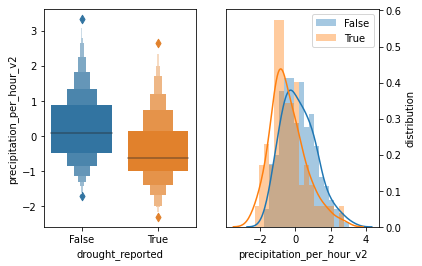

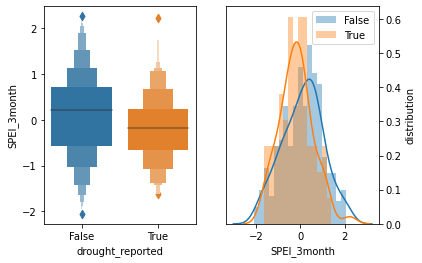

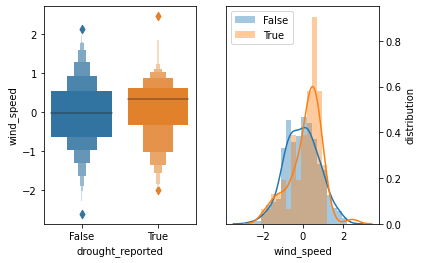

In [7]:
targets = feature_corr_sorted.columns

for target in targets:
    ibf.plot_dist(reduced_data,target,label_name)

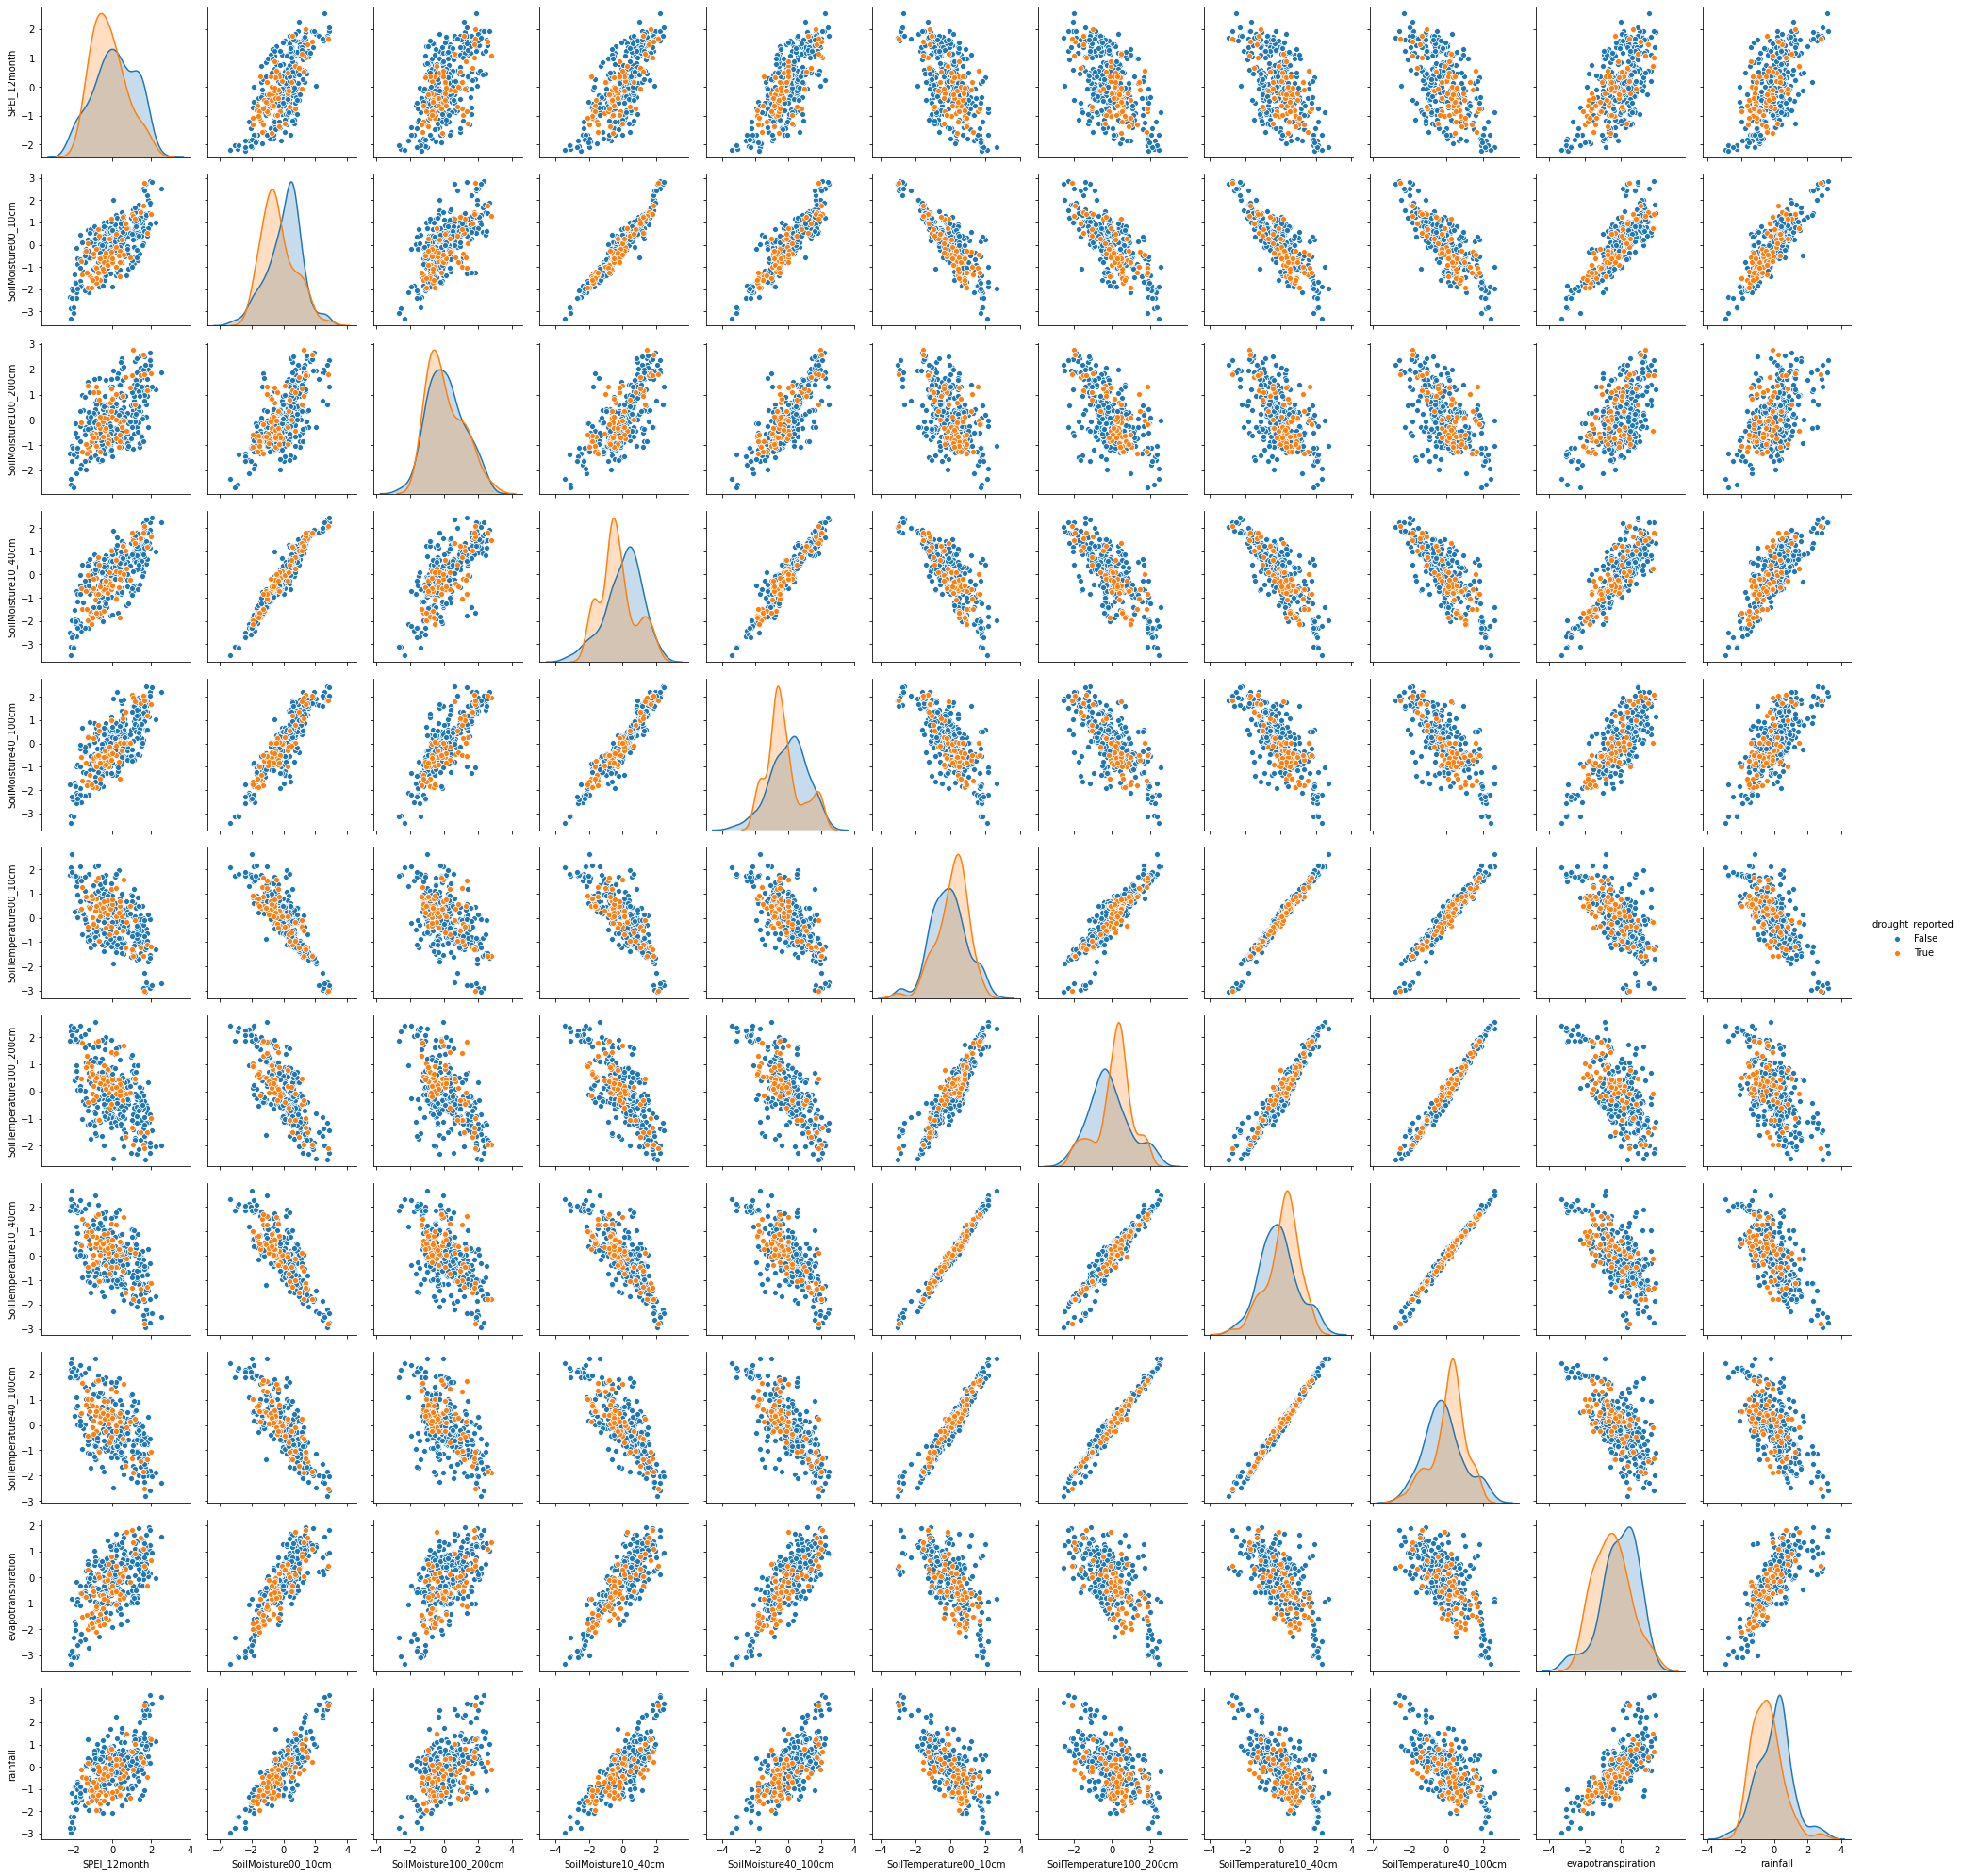

In [8]:
gruop_0 = feature_corr.columns[bicluster_model.row_labels_==0]
sns.pairplot(reduced_data, vars=gruop_0, hue=label_name);

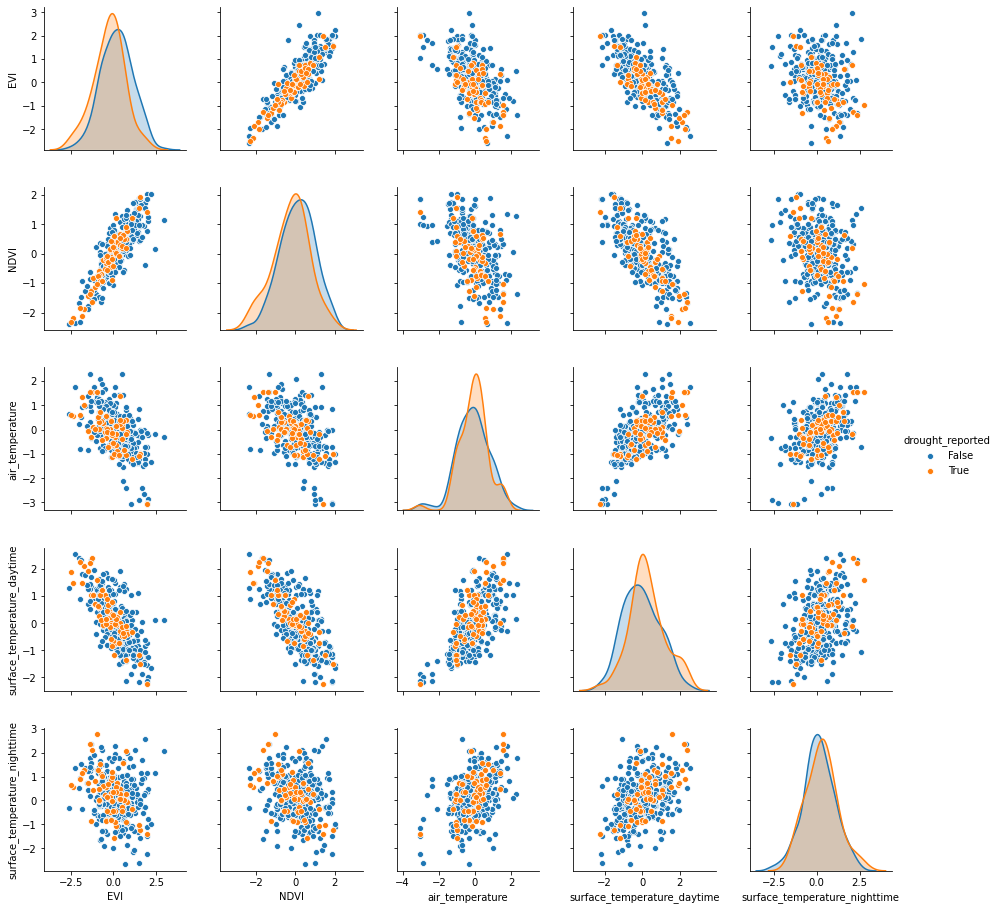

In [9]:
gruop_1 = feature_corr.columns[bicluster_model.row_labels_==1]
sns.pairplot(reduced_data, vars=gruop_1, hue=label_name);

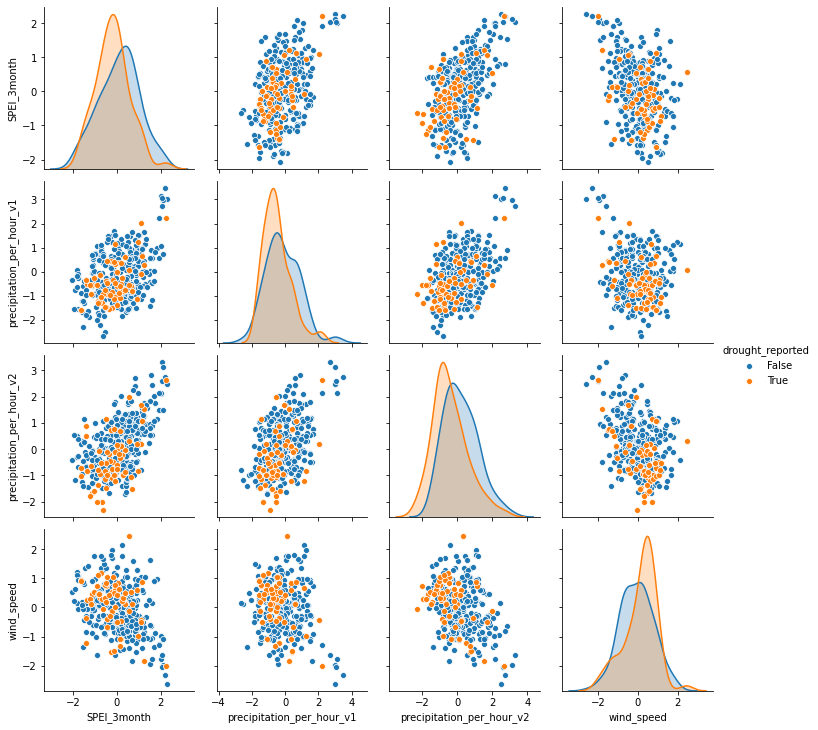

In [10]:
gruop_2 = feature_corr.columns[bicluster_model.row_labels_==2]
sns.pairplot(reduced_data, vars=gruop_2, hue=label_name);

# Fitting and Optimizing a Logistic Regression Model

In [11]:
np.random.seed(seed=10)

seeds = np.random.randint(1, 100, size=10)

C_array = np.concatenate((np.linspace(0.06,1,100),np.linspace(1,300,100)))

cv_scores = pd.DataFrame()

cv_scores['C'] = C_array

count = 0

for seed in seeds:
    
    count = count+1
    
    X,y,opt_model,mean_test_scores,std_test_scores =ibf.fit_Logreg_model(data, 
                                      selected_features, 
                                      label_name, 
                                      C_array,
                                      n_splits=3, 
                                      shuffle = True, 
                                      shuffle_seed=seed)
    
    cv_scores['shuffle_'+str(count)] = mean_test_scores
    
cv_scores.set_index('C',inplace=True)

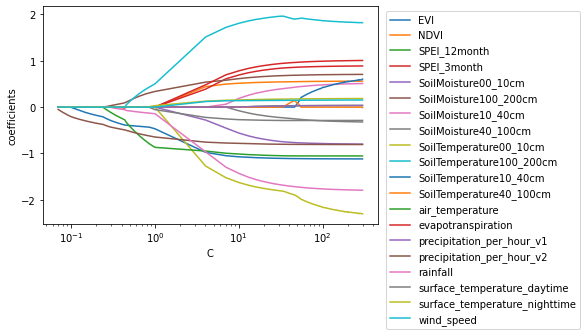

In [12]:
All_coefs = pd.DataFrame()

All_coefs['feature'] = selected_features

C_array = np.concatenate((np.linspace(0.07,1,100),np.linspace(1,300,100)))

fs = []

for C in C_array:
    opt_model.C = C
    opt_model.fit(X,y)
    y_pred = opt_model.predict(X)
    f = ibf.weighted_fscore(y, y_pred)
    fs.append(f)
    All_coefs[C] = opt_model.coef_.ravel()
    
All_coefs = All_coefs.set_index('feature').T.reset_index()
All_coefs.rename(columns={'index':'C'},inplace=True)

to_drop = (All_coefs.std()[All_coefs.std()==0].index)
All_coefs.drop(labels=to_drop,axis=1).plot(logx=True,x='C');
plt.legend(bbox_to_anchor=(1.01, 1));
plt.ylabel('coefficients');

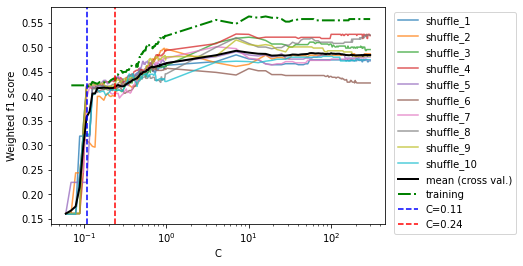

In [13]:
number_nonzero_coefs = All_coefs.set_index('C').astype(bool).sum(axis=1)
points = []
for n in range(1,number_nonzero_coefs.max()):
    point = number_nonzero_coefs[number_nonzero_coefs>n].index[0]
    points.append(point)

cv_scores.plot(logx=True,alpha=0.75)
ax=plt.gca()
cv_scores.mean(axis=1).plot(logx=True,color='k',lw=2,
                            label='mean (cross val.)',ax=ax)
ax=plt.gca()
ax.semilogx(C_array,fs,'-.',color='g',lw=2,label='training')

plt.axvline(x=points[0],color='b',ls='--',
            label='C='+str(round(points[0],2)))
plt.axvline(x=points[1],color='r',ls='--',
           label='C='+str(round(points[1],2)))

plt.ylabel('Weighted f1 score');
plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1));

For values of C>24, the average cross-validation score only midly increase from 0.42 and quickly saturates at 0.48.

Example: overfitting

In [14]:
overfit_coefs,_,_,_,_ = ibf.predict_Logreg_model(opt_model, X, y, C=0.3, 
                                              confusion_matrix=False)
overfit_coefs

feature      coef
15  precipitation_per_hour_v2 -0.432474
0                         EVI -0.292355
12            air_temperature -0.119130
5       SoilMoisture100_200cm  0.033452
16                   rainfall -0.008305

# Model Evaluation

In [15]:
C=0.238

coefs, predictions, pr, roc, auc = ibf.predict_Logreg_model(opt_model, 
                                                            X, y, C=C, 
                                                            confusion_matrix=True)

                 Confusion matrix
                 Score positive    Score negative
Actual positive        42                20
Actual negative       122               164

Accuracy  0.59
 
           Positive      Negative
Num case       62           286
Precision    0.26          0.89
Recall       0.68          0.57
F-score      0.37          0.70


Weighted Average F-score  0.43


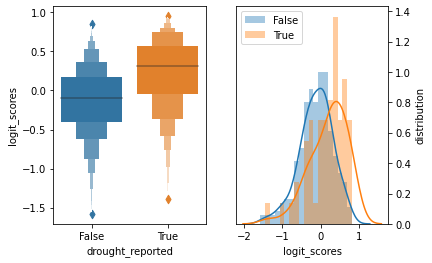

In [16]:
ibf.plot_dist(predictions, 'logit_scores', label_name)

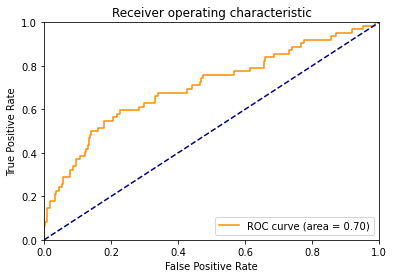

In [17]:
plt.plot(roc[0],roc[1],color='darkorange',
         label='ROC curve (area = %0.2f)' % auc)
plt.plot([0,1],[0,1],'--',color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic');

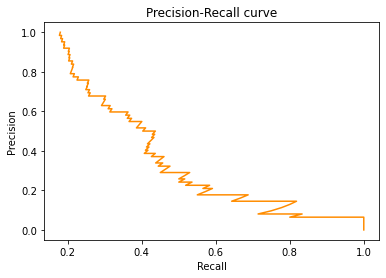

In [18]:
plt.plot(pr[0],pr[1],color='darkorange')
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.title('Precision-Recall curve');

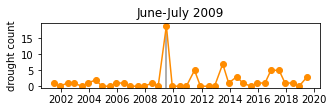

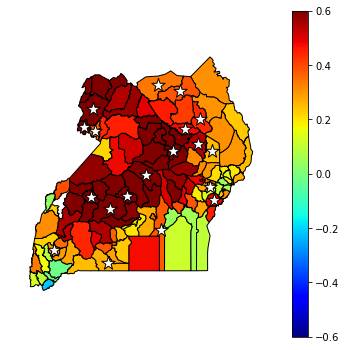

In [19]:
year = 2009
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

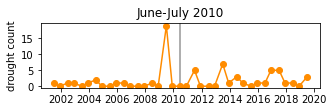

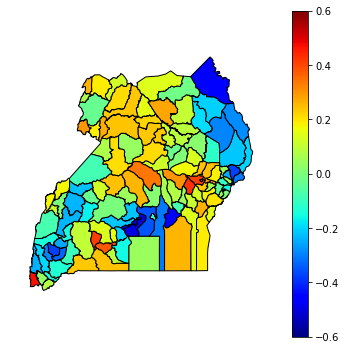

In [20]:
year = 2010
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

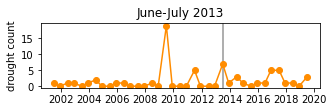

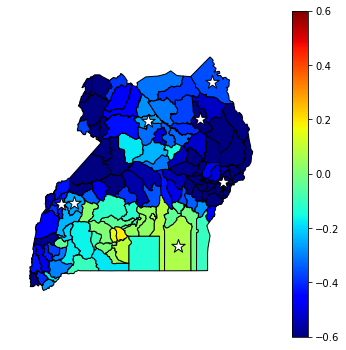

In [21]:
year = 2013
season = '6_7'
ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)

# Appendix: Global Drought Prediction

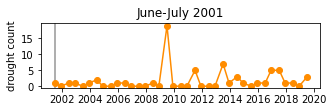

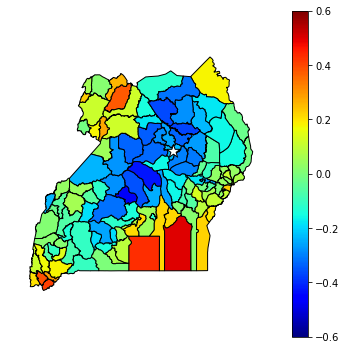

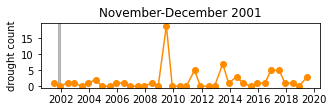

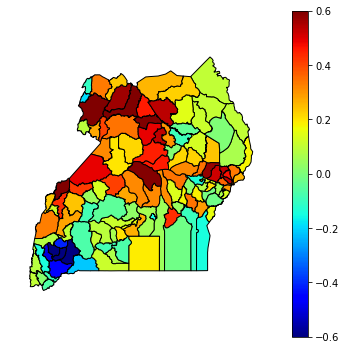

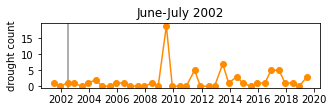

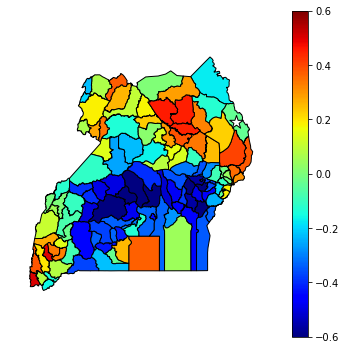

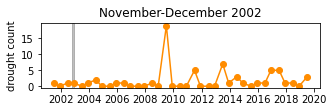

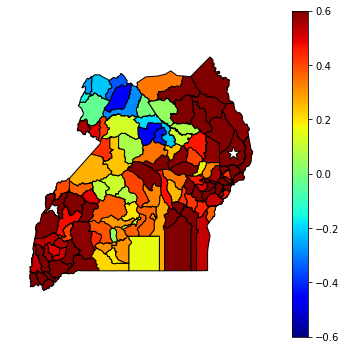

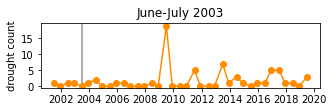

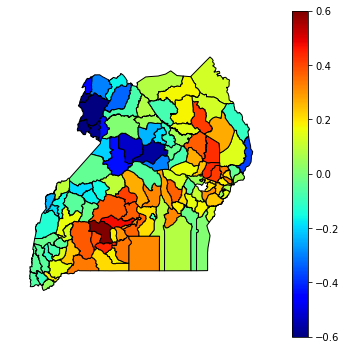

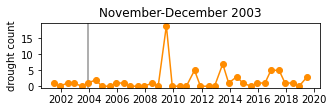

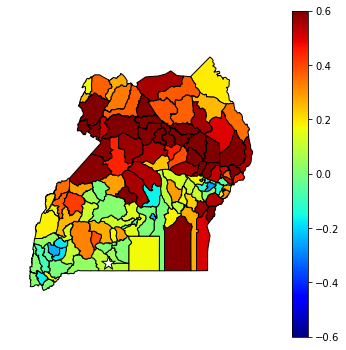

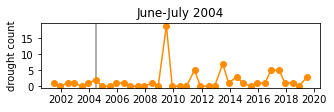

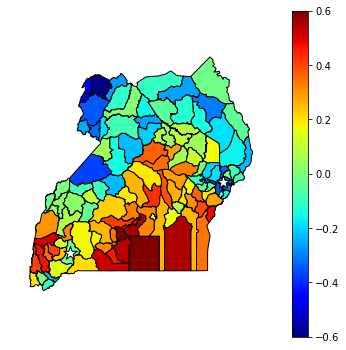

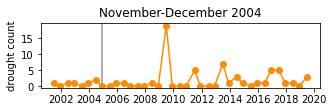

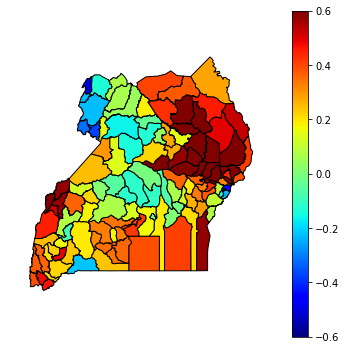

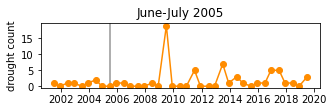

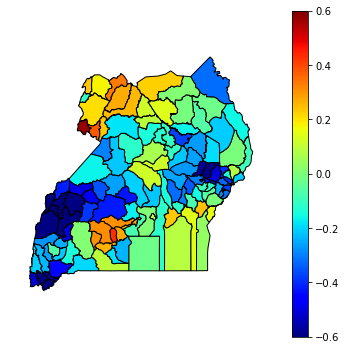

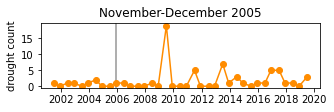

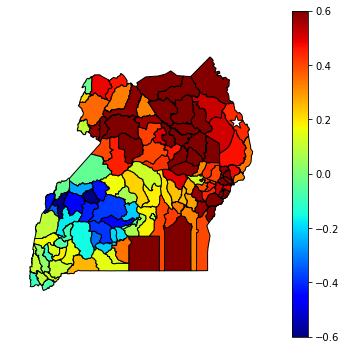

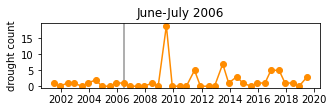

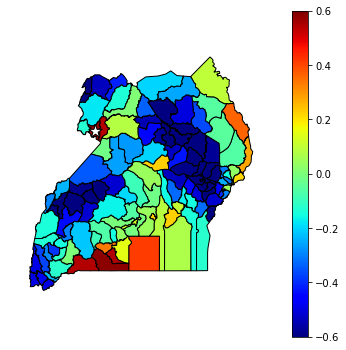

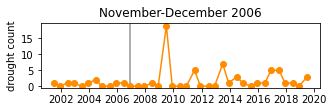

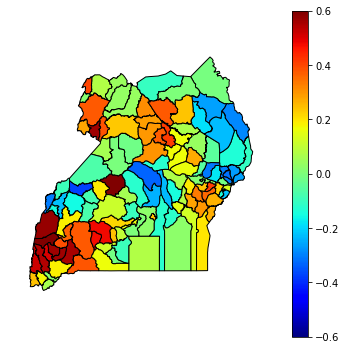

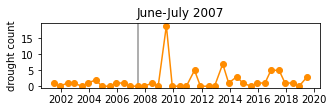

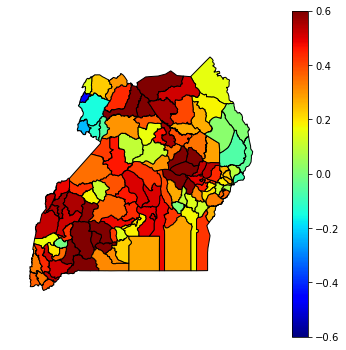

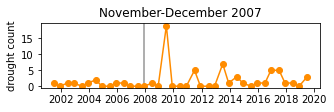

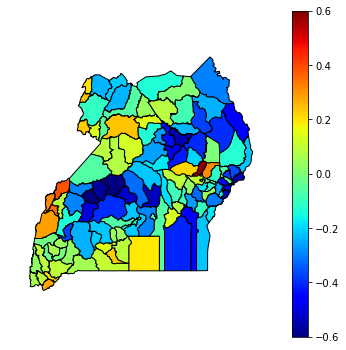

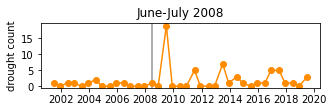

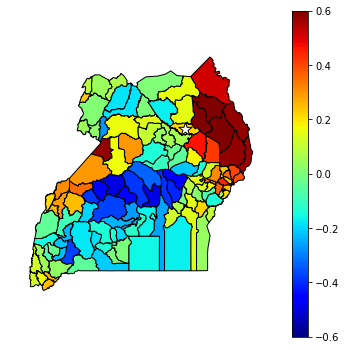

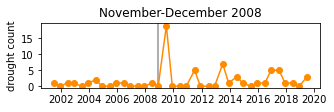

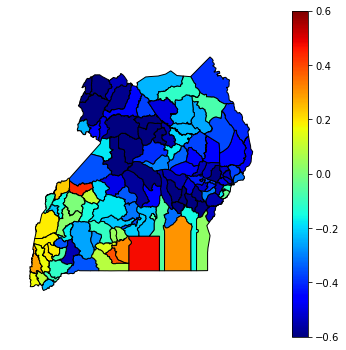

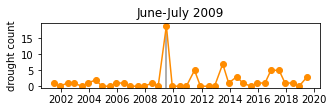

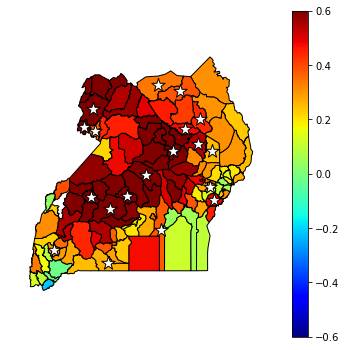

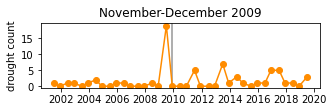

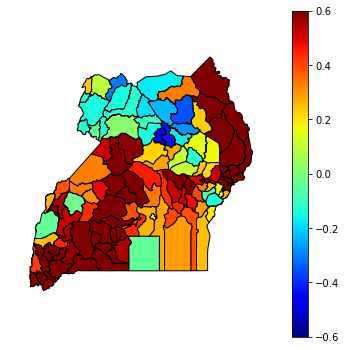

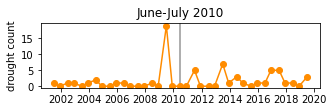

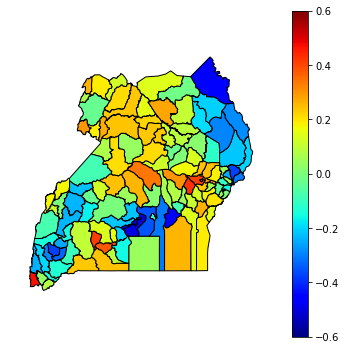

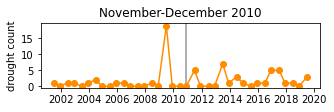

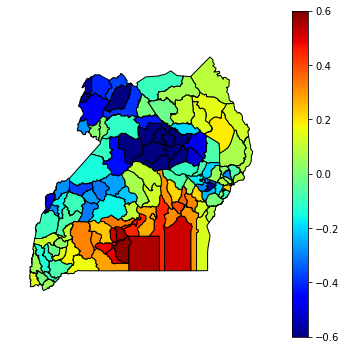

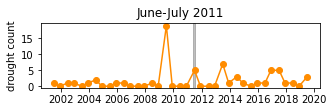

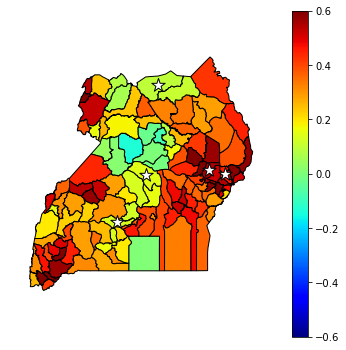

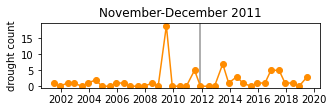

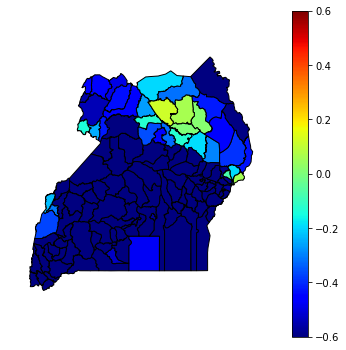

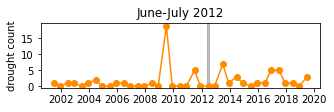

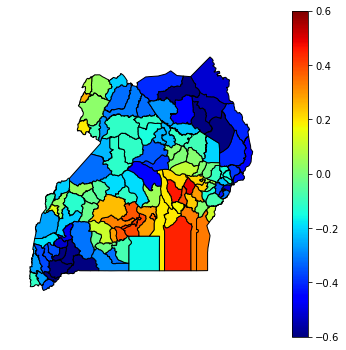

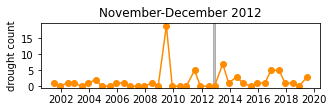

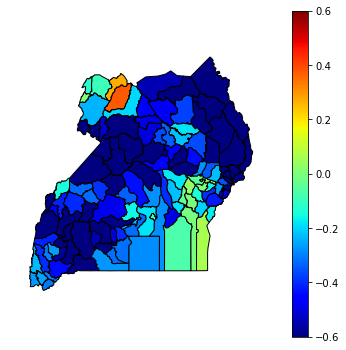

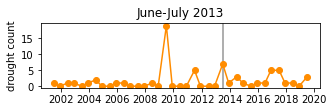

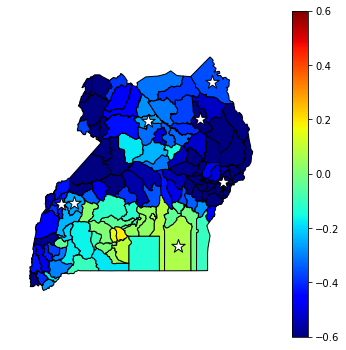

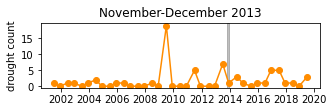

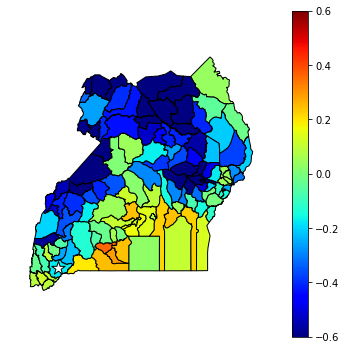

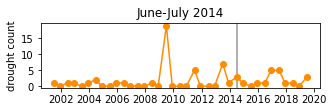

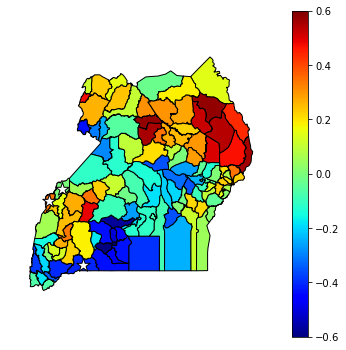

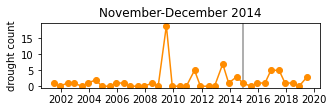

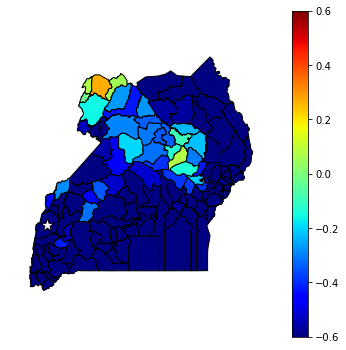

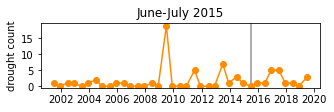

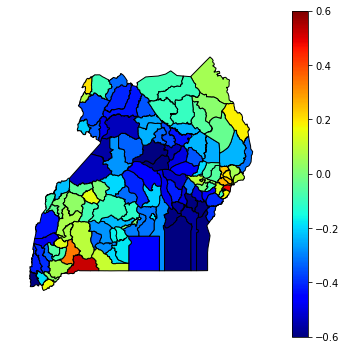

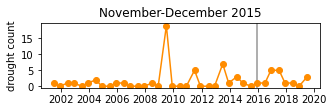

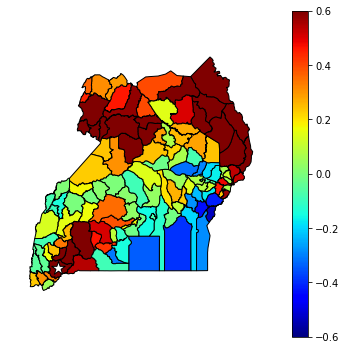

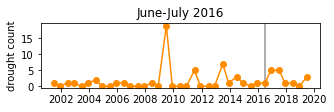

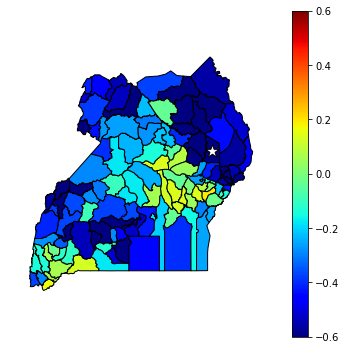

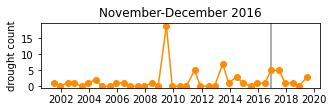

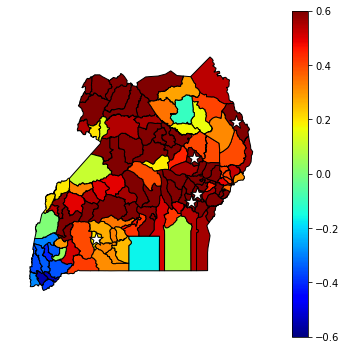

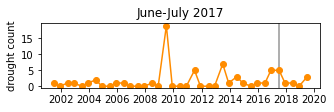

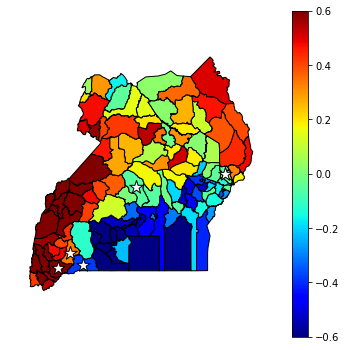

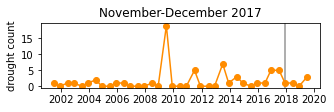

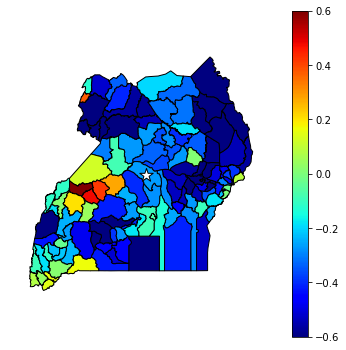

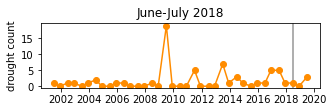

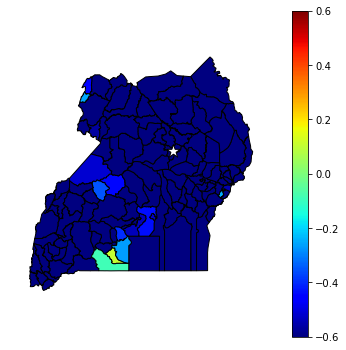

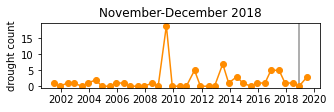

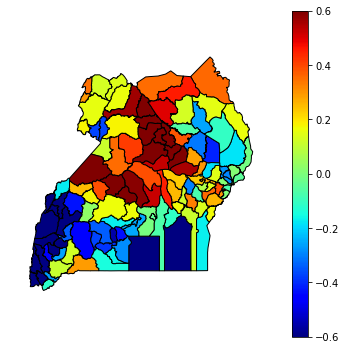

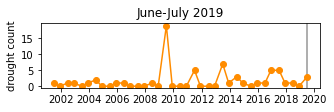

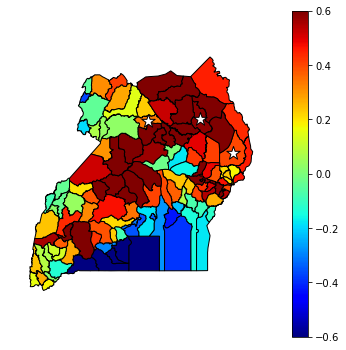

In [22]:
years = data.year.unique()
for year in years:
    seasons = np.flip(data[data.year==year]['Season'].unique())
    for season in seasons:
        ibf.visualize_droughts_uganda(data,opt_model,year,season,selected_features,
                             label_name)
        